In [32]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import glob
import mne
import json
import seaborn as sns

# Neurodsp libraries
from neurodsp import spectral

# SpecParam (FOOOF) libraries 
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting
import statsmodels.formula.api as smf
import pingouin as pg

import importlib
import eeg_preprocessing
importlib.reload(eeg_preprocessing)
from eeg_preprocessing import load_eeg, average_channels, get_channel_data, run_specparam

# Specparam on all subjects

In [2]:
data_dir = "/Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata"
# grab set files
set_files = glob.glob(os.path.join(data_dir, "sub-*", "ses-*", "eeg", "*_clean.set"))
print(f"Found {len(set_files)} cleaned EEG files.")

# map clean data to participant.tsv file
participants_path = "/Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/participants.tsv"
participants_df = pd.read_csv(participants_path, sep="\t")
participants_df.head()

Found 84 cleaned EEG files.


,participant_id,Gender,Age,SessionOrder,EEG_SamplingTime_Open_NS,EEG_SamplingTime_Closed_NS,EEG_SamplingTime_Open_SD,EEG_SamplingTime_Closed_SD,PVT_SamplingTime_NS,PVT_SamplingTime_SD,...,EQ,Buss_Perry,PSQI_GlobalScore,PSQI_item1,PSQI_item2,PSQI_item3,PSQI_item4,PSQI_item5,PSQI_item6,PSQI_item7
0,sub-01,M,22,NS->SD,8:57:52,9:04:40,8:18:28,8:25:34,9:27:23,9:23:08,...,NaN,NaN,4.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0
1,sub-02,M,21,NS->SD,9:47:46,9:53:24,8:54:10,8:59:50,10:16:59,10:00:47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-03,F,19,NS->SD,8:49:46,8:55:38,9:58:36,10:04:08,8:45:04,9:34:13,...,NaN,NaN,7.0,2.0,1.0,0.0,1.0,2.0,0.0,1.0
3,sub-04,M,22,NS->SD,9:53:56,9:59:34,9:07:02,9:12:26,10:05:35,10:06:28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-05,F,18,NS->SD,20:37:12,20:47:34,9:09:00,9:14:34,21:01:57,10:07:33,...,NaN,NaN,3.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# sorts subjects based on condition 
def get_condition(subject_id, session_id, participants_df):
    row = participants_df[participants_df["participant_id"] == subject_id]
    if row.empty:
        return None
    order = row["SessionOrder"].values[0]
    if order == "NS->SD":
        return "NS" if session_id == "ses-1" else "SD"
    if order == "SD->NS":
        return "SD" if session_id == "ses-1" else "NS"
    else:
        return None
    
all_results = []

for file_path in set_files:
    file_name = os.path.basename(file_path)
    subject_id = file_path.split(os.sep)[-4]  # sub-01
    session_id = file_path.split(os.sep)[-3]  # ses-1
    session_number = str(session_id.split("-")[1])  # "1"
    condition = get_condition(subject_id, session_id, participants_df)
    print(f"{subject_id} {session_id} → {condition})")
    
    result = run_specparam(subject_id, condition, file_path)
    result['Session ID'] = session_id
    all_results.append(result)

sub-22 ses-2 → NS)
Reading /Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata/sub-22/ses-2/eeg/sub-22_ses-2_task-eyesopen_eeg_clean.fdt
Reading 0 ... 75189  =      0.000 ...   293.707 secs...
sub-22 ses-1 → SD)
Reading /Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata/sub-22/ses-1/eeg/sub-22_ses-1_task-eyesopen_eeg_clean.fdt
Reading 0 ... 75021  =      0.000 ...   293.051 secs...
sub-25 ses-2 → NS)
Reading /Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata/sub-25/ses-2/eeg/sub-25_ses-2_task-eyesopen_eeg_clean.fdt
Reading 0 ... 72262  =      0.000 ...   282.273 secs...
sub-25 ses-1 → SD)
Reading /Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata/sub-25/ses-1/eeg/sub-25_ses-1_task-eyesopen_eeg_clean.fdt
Reading 0 ... 73976  =      0.000 ...   288.969 secs...
sub-71 ses-2 → SD)
Reading /Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/rawdata/sub-71/ses-2/eeg/sub-71_ses-2_task-eyesopen_eeg_clean.fdt
Reading 0 ... 69057  =    

In [4]:
# save results as csv
results_csv = []
for r in all_results:
    param_info = {
        "Subject ID": r["Subject ID"],
        "Condition": r["Session Type"],
        "Aperiodic Exponent": r["Aperiodic Exponent"],
        "Aperiodic Offset": r["Aperiodic Offset"],
        "Number of Peaks": r["Number of Peaks"]
    }
    
    results_csv.append(param_info)

# new folder to store results as files   
results_dir = "/Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata/specparam_results"
os.makedirs(results_dir, exist_ok=True)
    
specparam_df = pd.DataFrame(results_csv)
specparam_df = specparam_df.sort_values(by=["Subject ID", "Condition"])
specparam_df.to_csv(os.path.join(results_dir, "specparam_summary.csv"), index=False)
print(specparam_df[:]) 

   Subject ID Condition  Aperiodic Exponent  Aperiodic Offset  Number of Peaks
43     sub-17        NS               1.245           -11.434                2
44     sub-17        SD               1.182           -11.606                2
60     sub-18        NS               0.845           -11.817                1
61     sub-18        SD               1.085           -11.750                2
48     sub-19        NS               1.084           -11.549                3
..        ...       ...                 ...               ...              ...
64     sub-69        SD               1.160           -11.465                3
20     sub-70        NS               0.523           -11.926                3
19     sub-70        SD               1.159           -11.316                3
5      sub-71        NS               0.555           -12.188                3
4      sub-71        SD               1.226           -11.577                2

[84 rows x 5 columns]


In [ ]:
# find within-subject basleine


In [5]:
print("Average", specparam_df.groupby('Condition').mean(numeric_only=True)) # cutting out EC for right now becasue its only subj 1
print("Standard Deviation", specparam_df.groupby('Condition').std(numeric_only=True))

Average            Aperiodic Exponent  Aperiodic Offset  Number of Peaks
Condition                                                       
NS                   1.016293        -11.873220         2.146341
SD                   1.073465        -11.725326         2.139535
Standard Deviation            Aperiodic Exponent  Aperiodic Offset  Number of Peaks
Condition                                                       
NS                   0.199584          0.648017         0.823437
SD                   0.142908          0.392308         0.804197


  Subject ID  Aperiodic Exponent_NS  Aperiodic Exponent_SD
0     sub-17                  1.245                  1.182
1     sub-18                  0.845                  1.085
2     sub-19                  1.084                  1.051
3     sub-20                  1.190                  1.157
4     sub-21                  1.164                  1.228
  Subject ID  Aperiodic Offset_NS  Aperiodic Offset_SD
0     sub-17              -11.434              -11.606
1     sub-18              -11.817              -11.750
2     sub-19              -11.549              -11.839
3     sub-20              -11.085              -11.475
4     sub-21              -11.616              -11.799


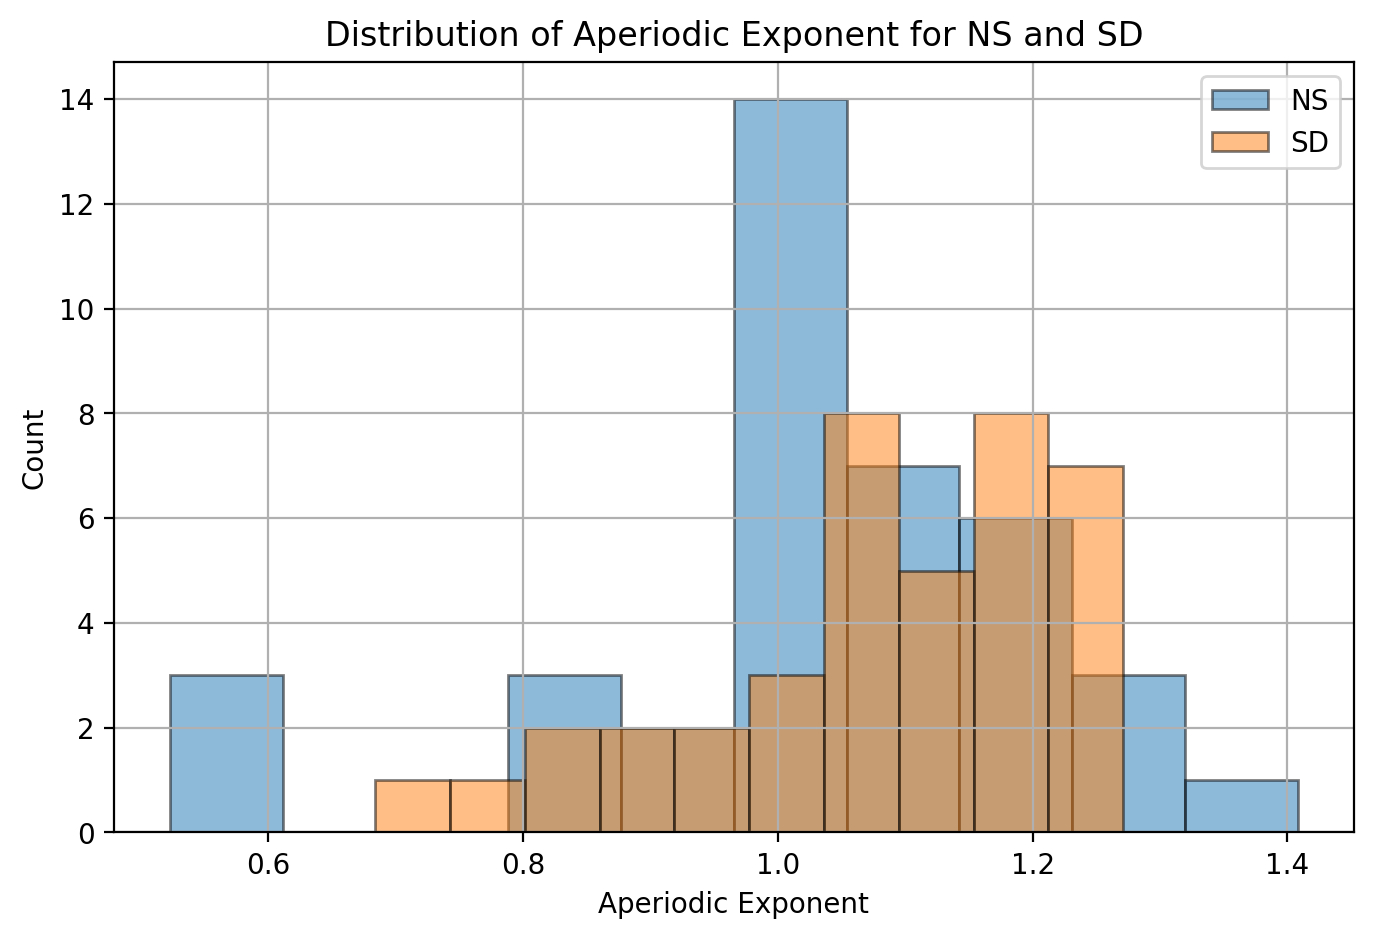

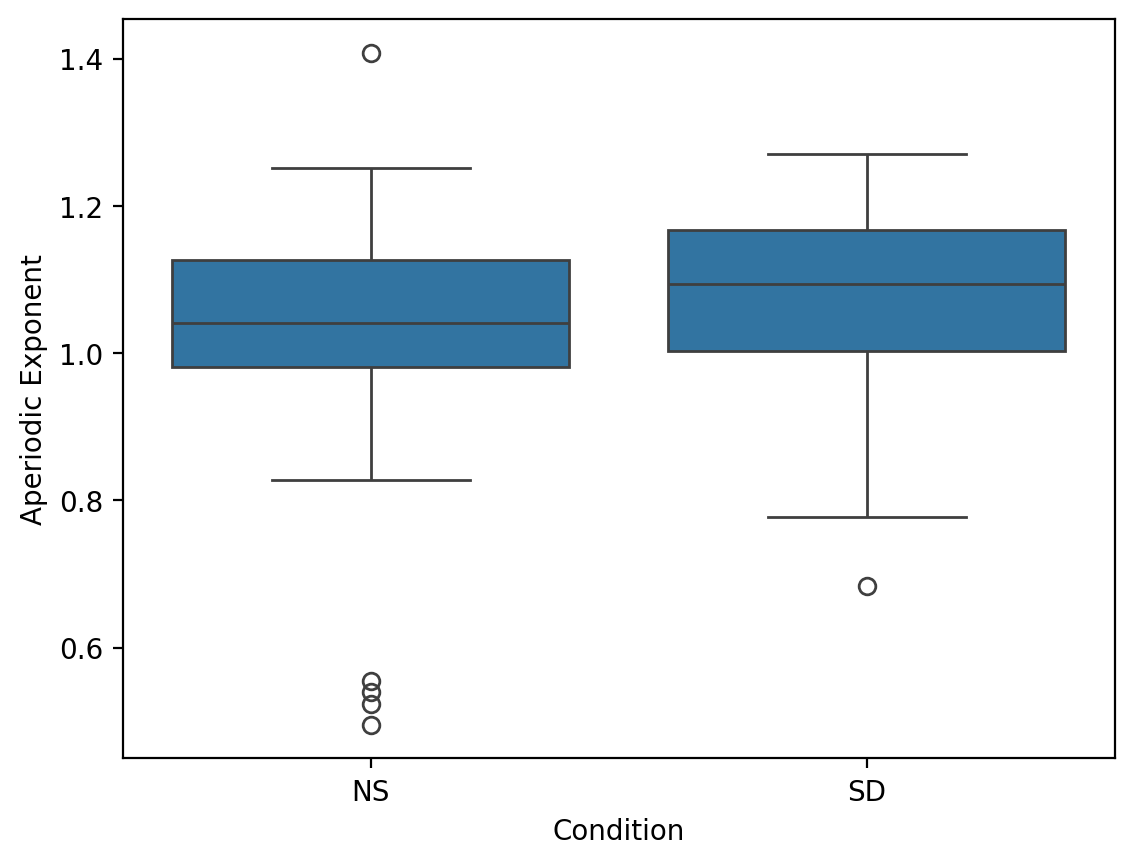

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

NS_df = specparam_df[specparam_df['Condition'] == 'NS']
SD_df = specparam_df[specparam_df['Condition'] == 'SD']
# dataset of aperiodic exponent of NS vs SD
merged = pd.merge(
    NS_df[['Subject ID', 'Aperiodic Exponent']],
    SD_df[['Subject ID', 'Aperiodic Exponent']],
    on='Subject ID',
    suffixes=('_NS', '_SD')
)
# dataset of aperiodc offset of NS vs SD
merged_offset = pd.merge(
    NS_df[['Subject ID', 'Aperiodic Offset']],
    SD_df[['Subject ID', 'Aperiodic Offset']],
    on='Subject ID',
    suffixes=('_NS', '_SD')
)
print(merged.head())
print(merged_offset.head())

# Histogram
plt.figure(figsize=(8, 5))
plt.hist(merged['Aperiodic Exponent_NS'], bins=10, alpha=0.5, label='NS', edgecolor='black')
plt.hist(merged['Aperiodic Exponent_SD'], bins=10, alpha=0.5, label='SD', edgecolor='black')
plt.xlabel('Aperiodic Exponent')
plt.ylabel('Count')
plt.title('Distribution of Aperiodic Exponent for NS and SD')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot of Aperiodic Exponent by Condition
sns.boxplot(x='Condition', y='Aperiodic Exponent', data=specparam_df[2:])
plt.show()

# Paired T-Test (normal sleep vs sleep deprivation)

In [7]:
from scipy.stats import ttest_rel
# Exponent t-test
t_stat, p_val = ttest_rel(
    merged['Aperiodic Exponent_NS'],
    merged['Aperiodic Exponent_SD']
)
print(f"Paired t-test on Aperiodic Exponent (NS vs SD): t = {t_stat:.3f}, p = {p_val:.3f}")

# offset t-test
t_stat, p_val = ttest_rel(
    merged_offset['Aperiodic Offset_NS'],
    merged_offset['Aperiodic Offset_SD']
)
print(f"Paired t-test on Aperiodic Offset (NS vs SD): t = {t_stat:.3f}, p = {p_val:.3f}")

Paired t-test on Aperiodic Exponent (NS vs SD): t = -1.505, p = 0.141
Paired t-test on Aperiodic Offset (NS vs SD): t = -1.578, p = 0.123


# Aperiodic activty correlated with age and gender

In [8]:
BASE_DIR = "/Users/elvissmith/Desktop/Voytek/OpenNeuro_NS_DS/alldata"
PARTICIPANT_FILE = os.path.join(BASE_DIR, "participants.tsv")
participants = pd.read_csv(PARTICIPANT_FILE, sep='\t')

### update participant file with cleaned data

In [9]:
specparam_df['Subject ID'] = specparam_df['Subject ID'].str.lower()

# new partiipant file with only cleaned subject data
cleaned_participant_df = []
for _, row in specparam_df.iterrows():
    sub_id = row['Subject ID']
    
    # match row value from specparam_df to main participants file
    if sub_id in participants['participant_id'].values:
        matched_row = participants.loc[participants['participant_id'] == sub_id]
        # append to new df
        cleaned_participant_df.append(matched_row.iloc[0])
        
cleaned_participant_df = pd.DataFrame(cleaned_participant_df)

### update specparam_df to include age and gender

In [10]:
# add age and gender to specparam df
age = []
gender = []
for _, row in specparam_df.iterrows():
    sub_id = row['Subject ID']
    if sub_id in cleaned_participant_df['participant_id'].values:
        matched_row = cleaned_participant_df.loc[cleaned_participant_df['participant_id'] == sub_id]
        age.append(matched_row.iloc[0]['Age'])
        gender.append(matched_row.iloc[0]['Gender'])
        
specparam_df['Age'] = age
specparam_df['Gender'] = gender
display(specparam_df)

,Subject ID,Condition,Aperiodic Exponent,Aperiodic Offset,Number of Peaks,Age,Gender
43,sub-17,NS,1.245,-11.434,2,18,F
44,sub-17,SD,1.182,-11.606,2,18,F
60,sub-18,NS,0.845,-11.817,1,21,M
61,sub-18,SD,1.085,-11.750,2,21,M
48,sub-19,NS,1.084,-11.549,3,18,M
...,...,...,...,...,...,...,...
64,sub-69,SD,1.160,-11.465,3,18,F
20,sub-70,NS,0.523,-11.926,3,19,M
19,sub-70,SD,1.159,-11.316,3,19,M
5,sub-71,NS,0.555,-12.188,3,21,M


In [11]:
# separate NS and SD
NS = specparam_df[specparam_df['Condition'] == 'NS']
SD = specparam_df[specparam_df['Condition'] == 'SD']

### Correlation of Age on Aperiodic Exponent and Offset

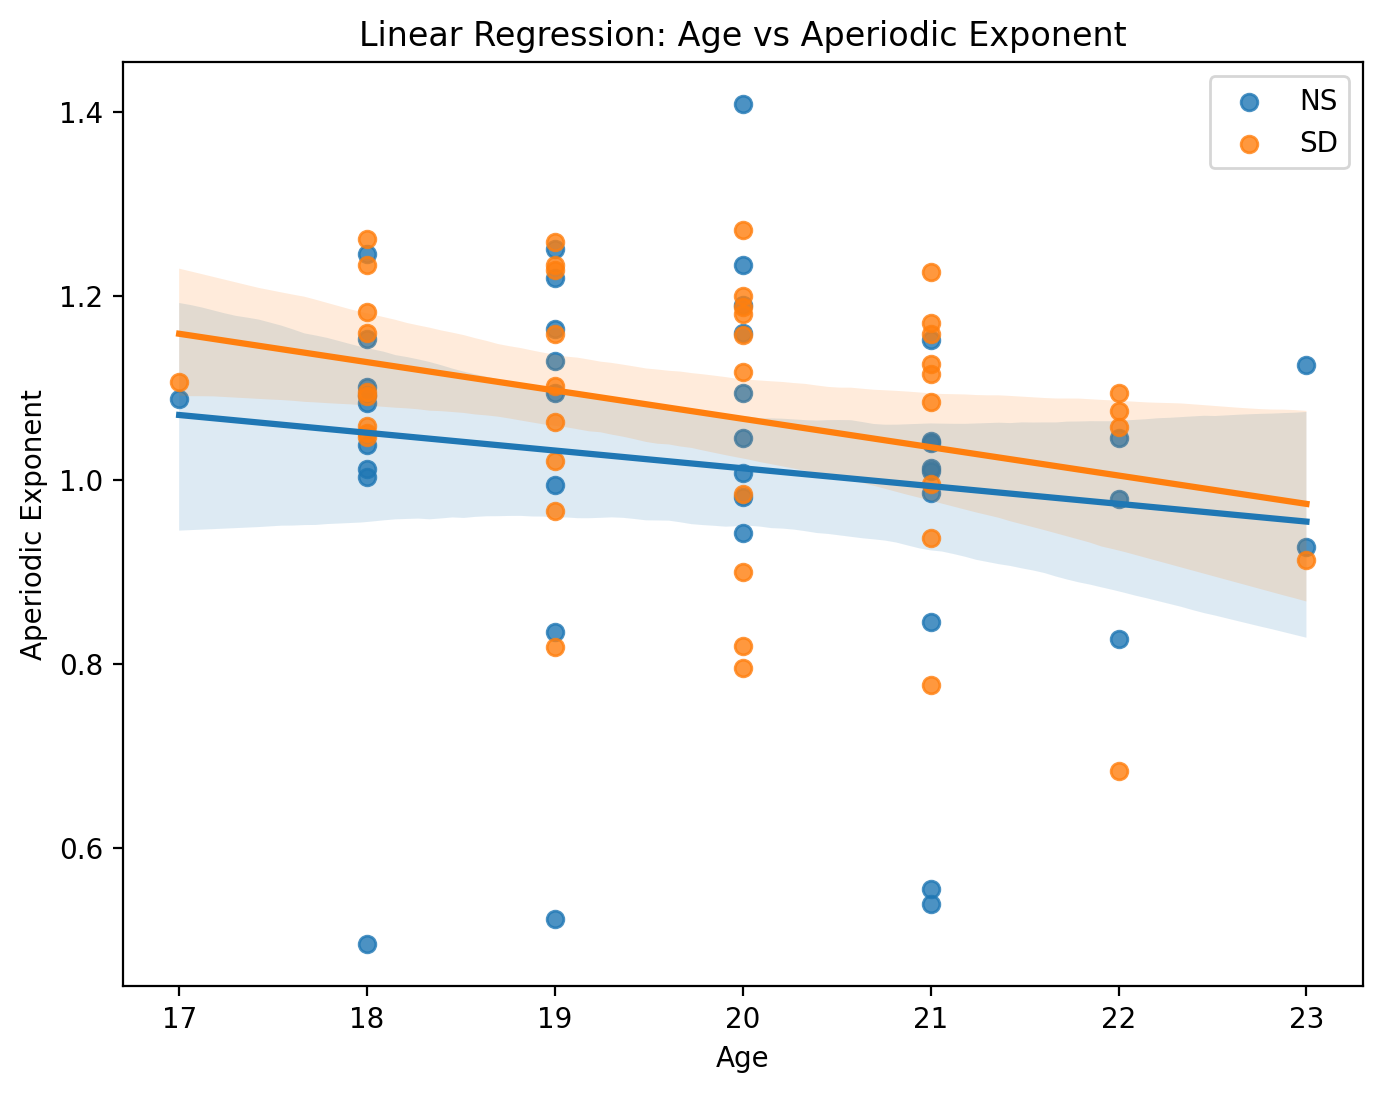

In [12]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Age', y='Aperiodic Exponent', data=NS, ci=95, label = 'NS')
sns.regplot(x='Age', y='Aperiodic Exponent', data=SD, ci=95, label = 'SD')
plt.xlabel('Age')
plt.ylabel('Aperiodic Exponent')
plt.title('Linear Regression: Age vs Aperiodic Exponent')
plt.legend()
plt.show()

In [13]:
import statsmodels.api as sm
def expo_regression(df, condition):
    age = sm.add_constant(df['Age'])
    expo = df['Aperiodic Exponent']
    model = sm.OLS(expo, age).fit()
    print(f"Regression for {condition} and Age:")
    print(model.summary())
    print("\n")
    
expo_regression(NS, 'NS')
#expo_regression(SD, 'SD')


Regression for NS and Age:
                            OLS Regression Results                            
Dep. Variable:     Aperiodic Exponent   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8435
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.364
Time:                        12:28:44   Log-Likelihood:                 8.8407
No. Observations:                  41   AIC:                            -13.68
Df Residuals:                      39   BIC:                            -10.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3988    

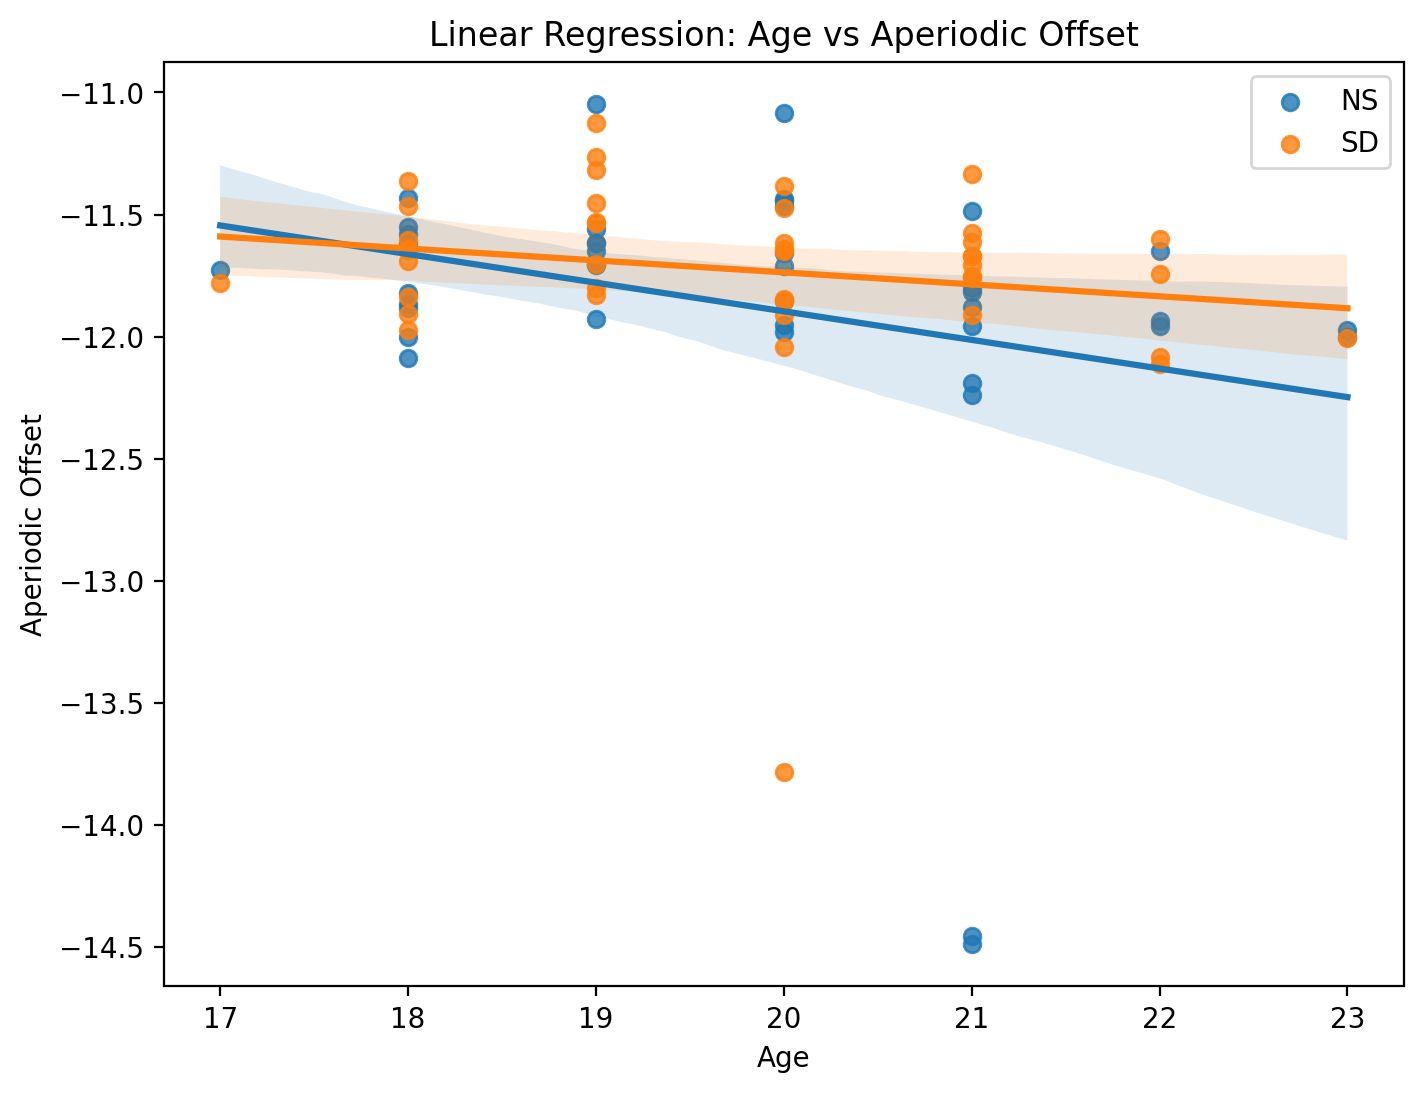

In [14]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Age', y='Aperiodic Offset', data=NS, ci=95, label = 'NS')
sns.regplot(x='Age', y='Aperiodic Offset', data=SD, ci=95, label = 'SD')
plt.xlabel('Age')
plt.ylabel('Aperiodic Offset')
plt.title('Linear Regression: Age vs Aperiodic Offset')
plt.legend()
plt.show()

In [15]:
def offset_regression(df, condition):
    age = sm.add_constant(df['Age'])
    offset = df['Aperiodic Offset']
    model = sm.OLS(offset, age).fit()
    print(f"Regression for {condition} and Age:")
    print(model.summary())
    print("\n")
    
#offset_regression(NS, 'NS')
offset_regression(SD, 'SD')

Regression for SD and Age:
                            OLS Regression Results                            
Dep. Variable:       Aperiodic Offset   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.345
Date:                Mon, 13 Oct 2025   Prob (F-statistic):              0.253
Time:                        12:28:44   Log-Likelihood:                -19.579
No. Observations:                  43   AIC:                             43.16
Df Residuals:                      41   BIC:                             46.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7576    

### Correlation between gender and exponent under both conditions

<function matplotlib.pyplot.show(close=None, block=None)>

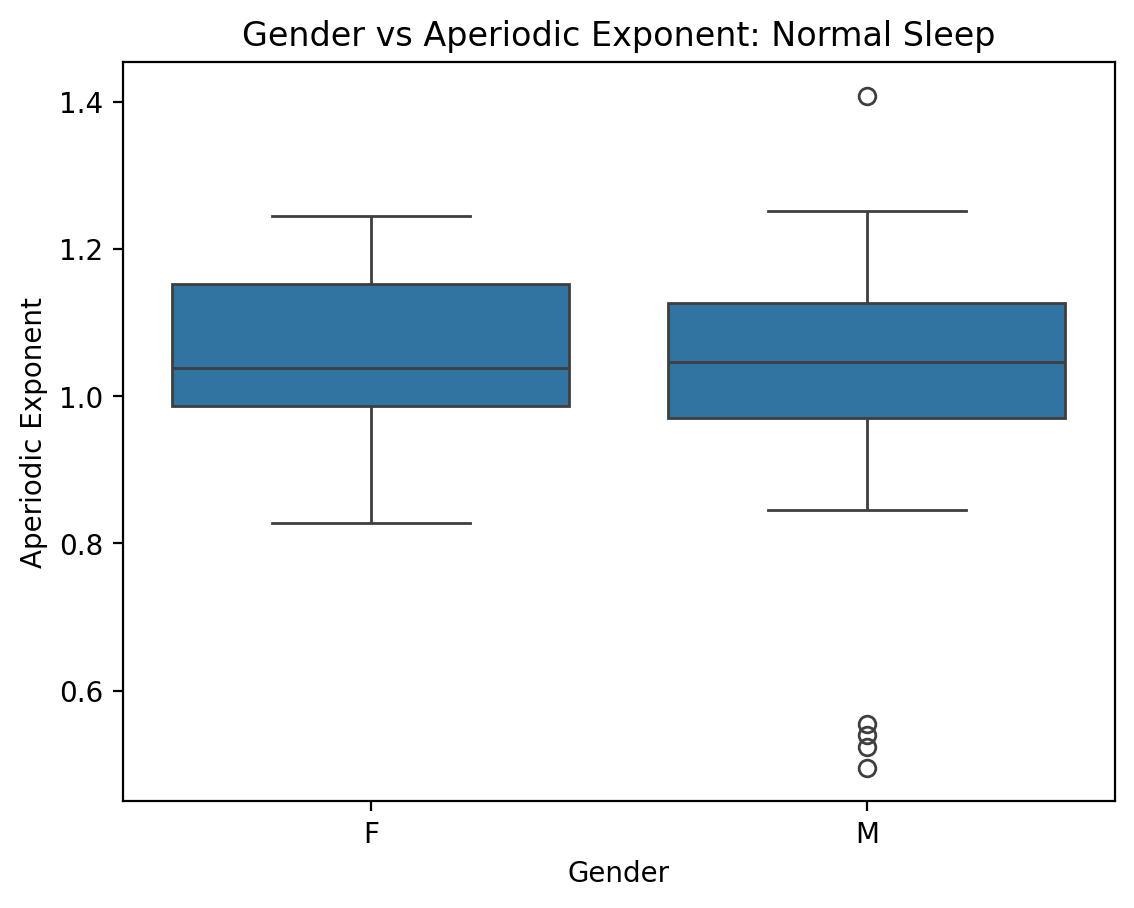

In [16]:
sns.boxplot(data = NS, x='Gender', y='Aperiodic Exponent')
plt.xlabel('Gender')
plt.ylabel('Aperiodic Exponent')
plt.title('Gender vs Aperiodic Exponent: Normal Sleep')
plt.show

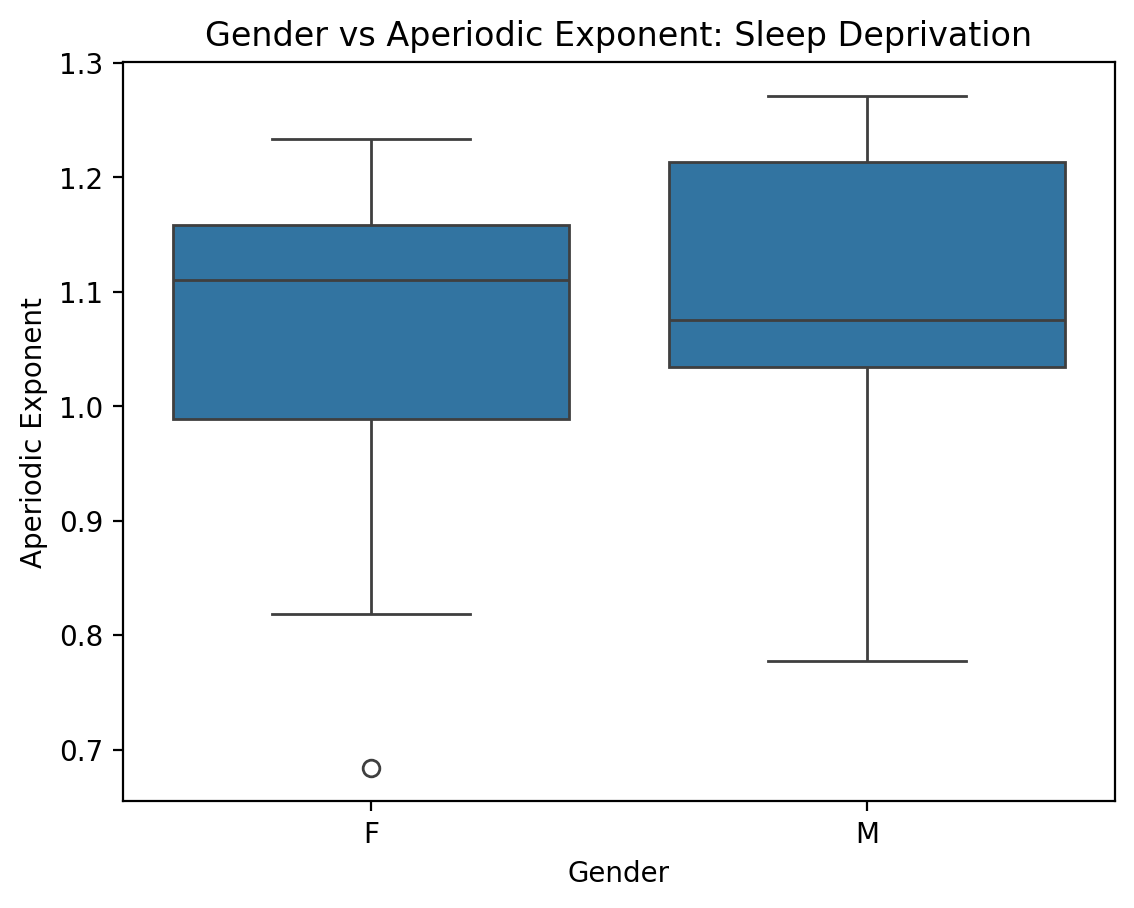

In [17]:
sns.boxplot(data = SD, x='Gender', y='Aperiodic Exponent')
plt.xlabel('Gender')
plt.ylabel('Aperiodic Exponent')
plt.title('Gender vs Aperiodic Exponent: Sleep Deprivation')
plt.show()

### Correlation between gender and offset under both conditions

<function matplotlib.pyplot.show(close=None, block=None)>

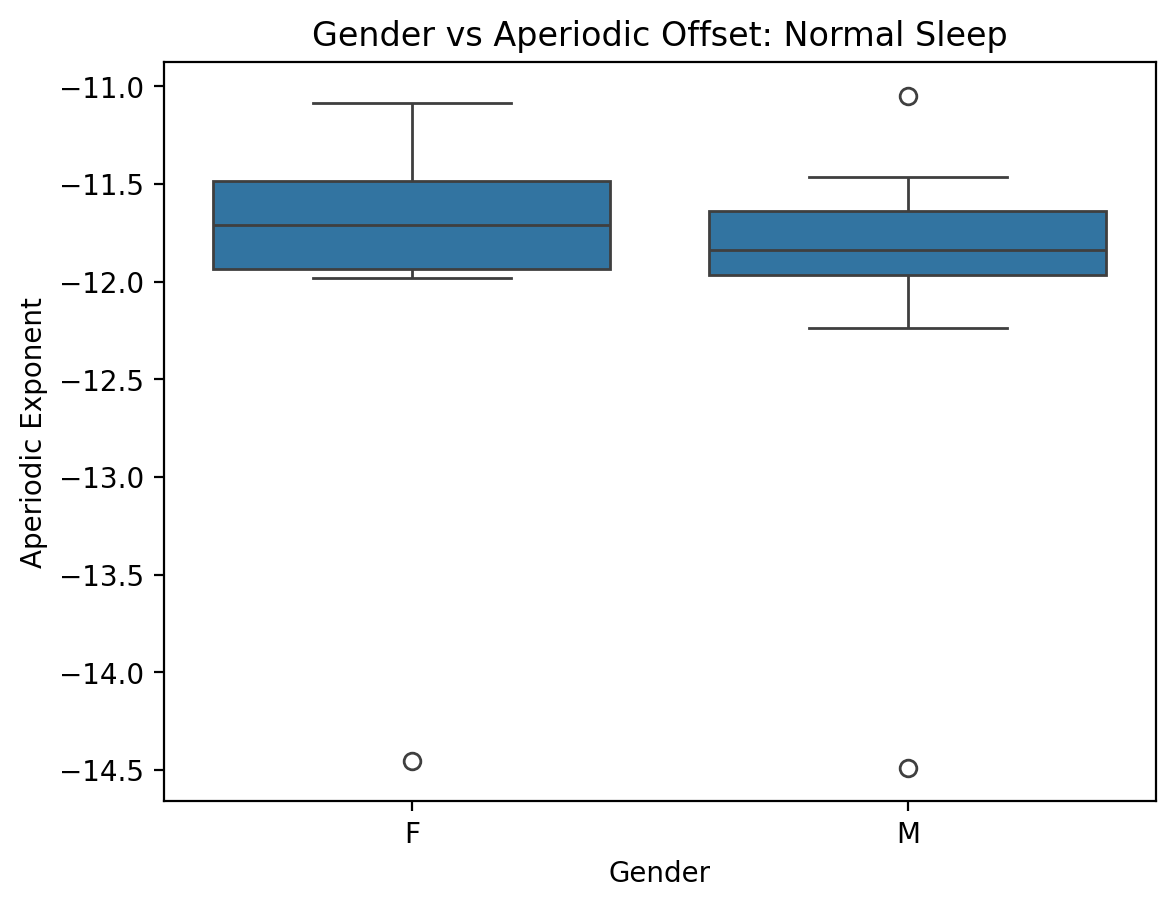

In [18]:
sns.boxplot(data = NS, x='Gender', y='Aperiodic Offset')
plt.xlabel('Gender')
plt.ylabel('Aperiodic Exponent')
plt.title('Gender vs Aperiodic Offset: Normal Sleep')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

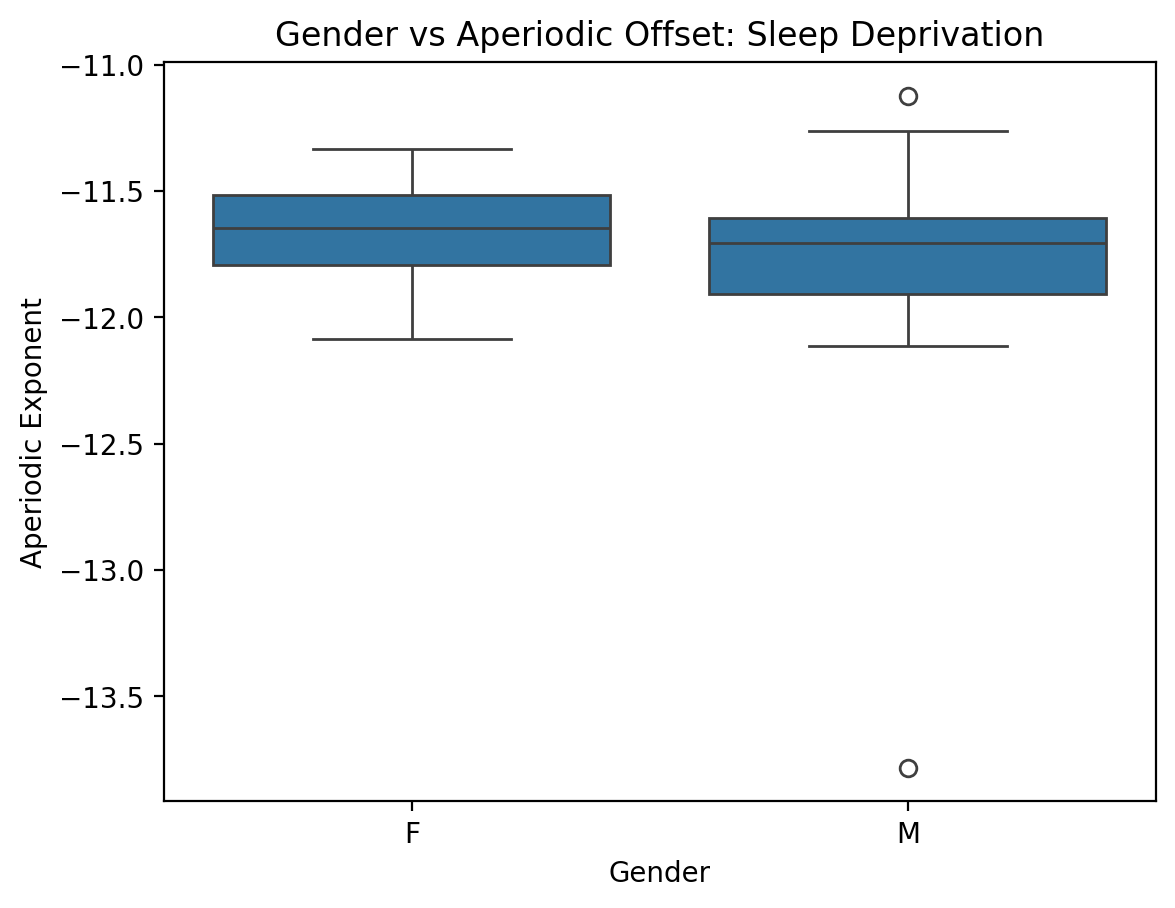

In [19]:
sns.boxplot(data = SD, x='Gender', y='Aperiodic Offset')
plt.xlabel('Gender')
plt.ylabel('Aperiodic Exponent')
plt.title('Gender vs Aperiodic Offset: Sleep Deprivation')
plt.show

In [20]:
# grab expo and offset for both genders (NS)
male_expo_NS = NS.loc[NS['Gender'] == 'M', 'Aperiodic Exponent']
female_expo_NS = NS.loc[NS['Gender'] == 'F', 'Aperiodic Exponent']
male_offset_NS = NS.loc[NS['Gender'] == 'M', 'Aperiodic Offset']
female_offset_NS = NS.loc[NS['Gender'] == 'F', 'Aperiodic Offset']

# grab expo and offset for both genders (SD)
male_expo_SD = SD.loc[SD['Gender'] == 'M', 'Aperiodic Exponent']
female_expo_SD = SD.loc[SD['Gender'] == 'F', 'Aperiodic Exponent']
male_offset_SD = SD.loc[SD['Gender'] == 'M', 'Aperiodic Offset']
female_offset_SD = SD.loc[SD['Gender'] == 'F', 'Aperiodic Offset']

In [21]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(male_expo_NS, female_expo_NS, equal_var=False) 
print(f"t-statistic for Aperiodic Exponent Between Male and Female (NS): {t_stat:.3f}, p-value: {p_val:.3f}")
t_stat, p_val = ttest_ind(male_offset_NS, female_offset_NS, equal_var=False)
print(f"t-statistic for Aperiodic Offset Between Male and Female (NS): {t_stat:.3f}, p-value: {p_val:.3f}")
t_stat, p_val = ttest_ind(male_expo_SD, female_expo_SD, equal_var=False) 
print(f"t-statistic for Aperiodic Exponent Between Male and Female (SD): {t_stat:.3f}, p-value: {p_val:.3f}")
t_stat, p_val = ttest_ind(male_offset_SD, female_offset_SD, equal_var=False)
print(f"t-statistic for Aperiodic Offset Between Male and Female (SD): {t_stat:.3f}, p-value: {p_val:.3f}")

t-statistic for Aperiodic Exponent Between Male and Female (NS): -0.932, p-value: 0.357
t-statistic for Aperiodic Offset Between Male and Female (NS): -0.343, p-value: 0.734
t-statistic for Aperiodic Exponent Between Male and Female (SD): 0.381, p-value: 0.705
t-statistic for Aperiodic Offset Between Male and Female (SD): -1.070, p-value: 0.293


In [22]:
# Levene's Test for Variance
from scipy.stats import levene

stat_ns, pval_ns = levene(male_expo_NS, female_expo_NS)
print(f"NS Condition: Levene’s test statistic on Aperiodic Exponent = {stat_ns:.3f}, p-value = {pval_ns:.3f}")

stat_sd, pval_sd = levene(male_expo_SD, female_expo_SD)
print(f"SD Condition: Levene’s test statistic on Aperiodic Exponent = {stat_sd:.3f}, p-value = {pval_sd:.3f}")

stat_ns, pval_ns = levene(male_offset_NS, female_offset_NS)
print(f"NS Condition: Levene’s test statistic on Aperiodic Offset = {stat_ns:.3f}, p-value = {pval_ns:.3f}")

stat_sd, pval_sd = levene(male_offset_SD, female_offset_SD)
print(f"SD Condition: Levene’s test statistic on Aperiodic Offset = {stat_sd:.3f}, p-value = {pval_sd:.3f}")

NS Condition: Levene’s test statistic on Aperiodic Exponent = 1.931, p-value = 0.172
SD Condition: Levene’s test statistic on Aperiodic Exponent = 0.226, p-value = 0.637
NS Condition: Levene’s test statistic on Aperiodic Offset = 0.056, p-value = 0.815
SD Condition: Levene’s test statistic on Aperiodic Offset = 1.269, p-value = 0.267


# Mixed Linear Model

In [ ]:
# Convert categorical variables
specparam_df["Condition"] = specparam_df["Condition"].astype("category")
specparam_df["Gender"] = specparam_df["Gender"].astype("category")

# Model: Aperiodic Exponent
exponent_model = smf.mixedlm(
    "Q('Aperiodic Exponent') ~ Q('Condition') + Age + Gender",
    data=specparam_df,
    groups=specparam_df["Subject ID"]
)
# Model: Aperiodic Offset
offset_model = smf.mixedlm(
    "Q('Aperiodic Offset') ~ Q('Condition') + Age + Gender",
    data=specparam_df,
    groups=specparam_df["Subject ID"]
)

LMM_exponent_result = exponent_model.fit()
LMM_offset_result = offset_model.fit()
print(LMM_exponent_result.summary())
print(LMM_offset_result.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Q('Aperiodic Offset')
No. Observations: 84      Method:             REML                 
No. Groups:       45      Scale:              0.2721               
Min. group size:  1       Log-Likelihood:     -69.2829             
Max. group size:  2       Converged:          Yes                  
Mean group size:  1.9                                              
-------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------
Intercept             -10.108    0.790 -12.792 0.000 -11.657 -8.559
Q('Condition')[T.SD]    0.139    0.114   1.218 0.223  -0.085  0.363
Gender[T.M]            -0.111    0.115  -0.961 0.337  -0.337  0.115
Age                    -0.086    0.039  -2.180 0.029  -0.163 -0.009
Group Var               0.000    0.105                         

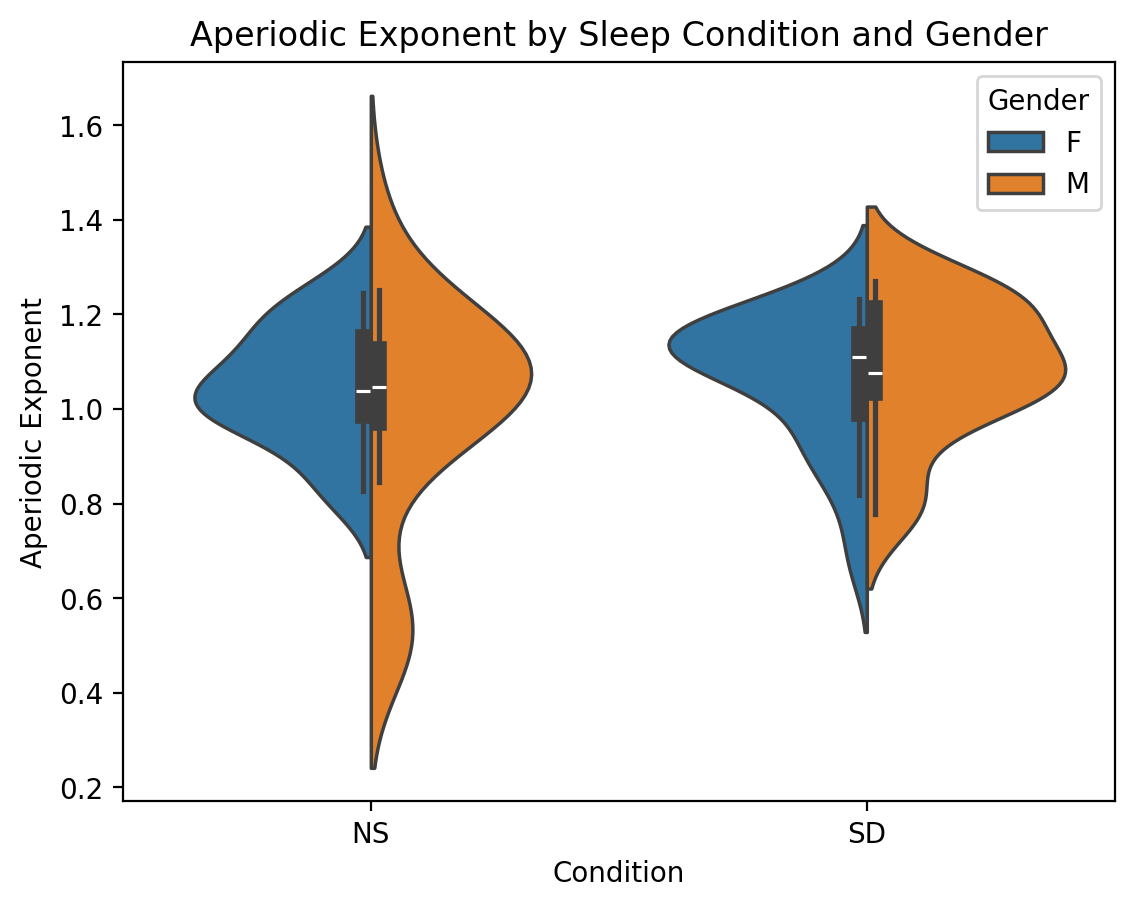

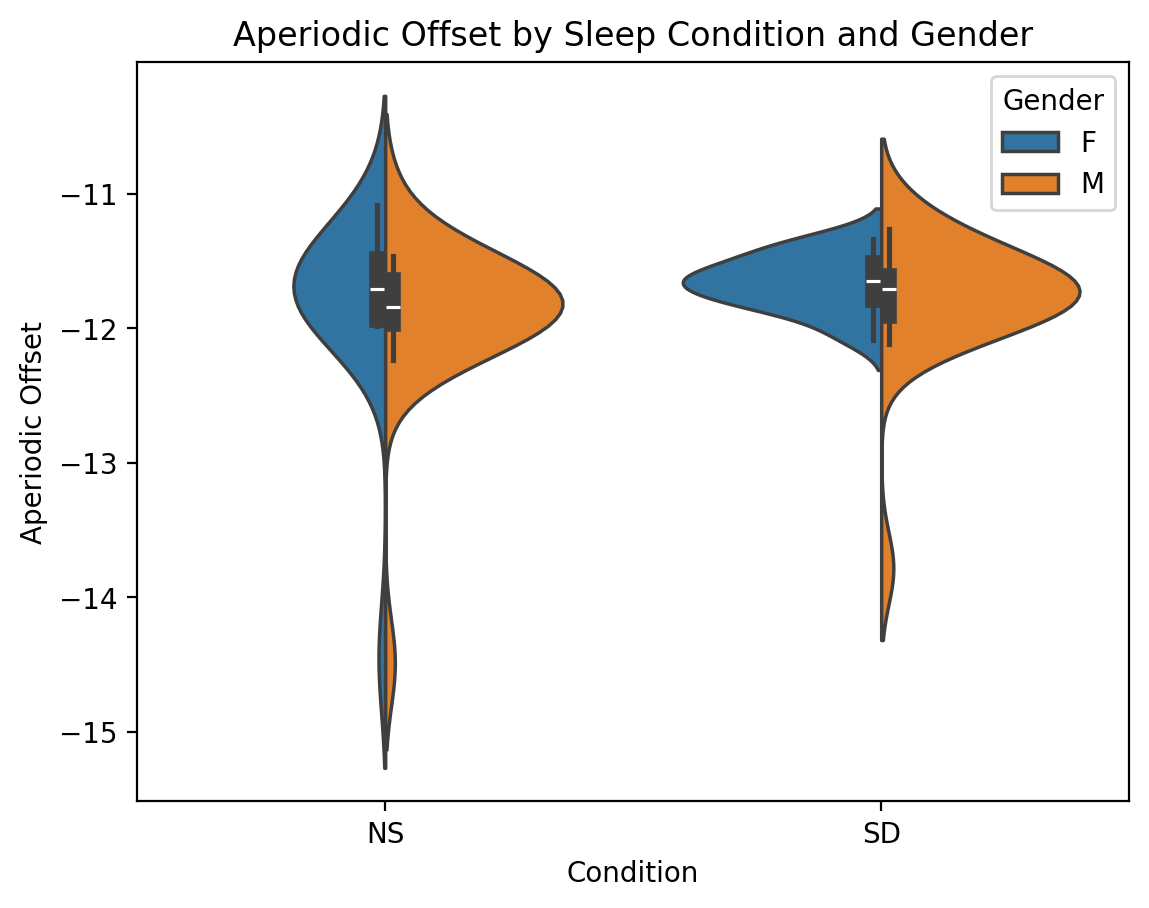

In [31]:
# Exponent LMM visual
sns.violinplot(
    data=specparam_df,
    x="Condition",
    y="Aperiodic Exponent",
    hue="Gender",
    split=True
)
plt.title("Aperiodic Exponent by Sleep Condition and Gender")
plt.show()

# Offset LMM visual
sns.violinplot(
    data=specparam_df,
    x="Condition",
    y="Aperiodic Offset",
    hue="Gender",
    split=True
)
plt.title("Aperiodic Offset by Sleep Condition and Gender")
plt.show()

In [39]:
aov = pg.rm_anova(
    data= specparam_df,
    dv='Aperiodic Exponent',
    within='Condition',
    subject='Subject ID',
    detailed=True
)
print(aov)

      Source        SS  DF        MS         F     p-unc       ng2  eps
0  Condition  0.049201   1  0.049201  2.264129  0.140668  0.023141  1.0
1      Error  0.825765  38  0.021731       NaN       NaN       NaN  NaN
